# Lab 2 - GRU and text classification

## Structure of weights of GRU
Gated Recurrent Unit (GRU) is a simplified variation on the LSTM designed to solve the vanishing gradient problem. It uses two gates: update gate and reset gate. 

### Update gate
$$
z_t = \sigma(W^{(z)}x_t + U^{(z)}h_{t-1})
$$

$z_t$ is a value between $0$ and $1$, indicating how much information from the input at time step $t$, i.e. $x_t$, should be preserved.

### Reset gate
$$
r_t = \sigma(W^{(r)}x_t + U^{(r)}h_{t-1})
$$
$r_t$ us a value between $0$ and $1$, indicating how much information from the past, i.e. $h_{t-1}$, should be forgotten. 

### Preliminary current memory content
$$
h'_t = \tanh(Wx_t + r_t \odot Uh_{t-1})
$$
The preliminary current memory is composed of new memory content, which involves the input $x_t$, as well as information from the past, filtered by the reset gate.

### Final current memory content
$$
h_t = z_t \odot h_{t-1} + (1 - z_t) \odot h'_t
$$
The final current memory is based on the weighted combination of information from the past, i.e. $h_{t-1}$, and the preliminary current memory content, i.e. $h'_t$.

## Classification with GRU

### Setup

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

2022-10-12 20:11:03.820678: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

### Prepare the data
For this example, we will use the yelp polarity review dataset. You can find details about the dataset [here](https://www.tensorflow.org/datasets/catalog/yelp_polarity_reviews).

In [3]:
dataset, info = tfds.load("yelp_polarity_reviews", with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset["train"], dataset["test"]

print(train_dataset.element_spec)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


2022-10-12 20:11:07.529880: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We can examine the content of the dataset. Then, we can shuffle the data and create batches for training.

In [4]:
for example, label in train_dataset.take(1):
    print("example\t", example)
    print("label\t", label)
    
print(example.shape)

example	 tf.Tensor(b"The Groovy P. and I ventured to his old stomping grounds for lunch today.  The '5 and Diner' on 16th St and Colter left me with little to ask for.  Before coming here I had a preconceived notion that 5 & Diners were dirty and nasty. Not the case at all.\\n\\nWe walk in and let the waitress know we want to sit outside (since it's so nice and they had misters).  We get two different servers bringing us stuff (talk about service) and I ask the one waitress for recommendations.  I didn't listen to her, of course, and ordered the Southwestern Burger w/ coleslaw and started with a nice stack of rings.\\n\\nThe Onion Rings were perfectly cooked.  They looked like they were prepackaged, but they were very crispy and I could actually bite through the onion without pulling the entire thing out (don't you hate that?!!!)\\n\\nThe Southwestern Burger was order Medium Rare and was cooked accordingly.  Soft, juicy, and pink with a nice crispy browned outer layer that can only be 

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [6]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"I used to work with Lance. Great to see he's gone to start his new life and excited to see him living his dream. I stopped in for dinner on Saturday and Sunday. Huge selection of beers. I love the Flights and the  Fried Apples and Vanilla ice cream. Yummy."
 b'Open, free place to create and collaborate. Try a Wednesday night \\""hacknight\\"" or Wednesday \\""brownbag\\"" lunch session for your first time. Just walk in, find an open desk, get on the free wi-fi and chat with those around you.'
 b"They do not have bridal gowns, just all the extras, including the biggest selection of bridesmaid dresses in the Valley from every designer you've been pinning - it's worth the drive! \\n\\nIf, like the upset bridezillas who gave low ratings for customer service issues, you need to be wooed while picking out an ugly dress you will never wear again, by all means, go somewhere else. It is low frills - and in fact, the first time I went there, I was told to just go home and order online

Tensorflow Keras provides `TextVectorization`, a layer/class for processing and encoding text into tokens for training. We will use its default version in this example. 

First, we will use the `adapt` method to set the vocabulary based on `train_dataset`. 

In [7]:
VOCAB_SIZE = 5000
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

Once that is done, we will encode texts into indices. By default, the tensors of indices are 0-padded to the longest sequence in the batch, if we do not set a fixed `output_sequence_length`.

In [8]:
encoded_example = text_vectorizer(example)[:3].numpy()
print(example[:3])
print(encoded_example)
print(encoded_example.shape)

tf.Tensor(
[b"I used to work with Lance. Great to see he's gone to start his new life and excited to see him living his dream. I stopped in for dinner on Saturday and Sunday. Huge selection of beers. I love the Flights and the  Fried Apples and Vanilla ice cream. Yummy."
 b'Open, free place to create and collaborate. Try a Wednesday night \\""hacknight\\"" or Wednesday \\""brownbag\\"" lunch session for your first time. Just walk in, find an open desk, get on the free wi-fi and chat with those around you.'
 b"They do not have bridal gowns, just all the extras, including the biggest selection of bridesmaid dresses in the Valley from every designer you've been pinning - it's worth the drive! \\n\\nIf, like the upset bridezillas who gave low ratings for customer service issues, you need to be wooed while picking out an ugly dress you will never wear again, by all means, go somewhere else. It is low frills - and in fact, the first time I went there, I was told to just go home and order onl

### Build the classification model
We will employ `tf.keras.Sequential` to combine a sequence of Keras layers to build the model. 

First, we use `TextVectorization` layer to convert text to a sequence of token indicies, as is shown above. 

Then, we add a `Embedding` layer that can be trained to produce a vector for each token. This adopts the idea of Word2Vec to reduce the dimension of word representations (i.e. instead of one-hot encoding vector whose length is the size of the vocabulary, we have a smaller but more informational word vectors). 

After that, we utilize a recurrent neural network (RNN), in this example, a GRU, to process sequence input by iterating through the elements. Since we are approaching a text classification task, we will process the input both forward and backward through the RNN layer to obtain better representations on the text sequences. 

Lastly, once we obtain the text representations as single vectors using RNN, we use `tf.keras.layers.Dense` to do some further learning on the data, and generate a single logit as the classification output.

In [9]:
model = tf.keras.Sequential([
    text_vectorizer, 
    tf.keras.layers.Embedding(
        input_dim=len(text_vectorizer.get_vocabulary()),
        output_dim=256,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256)),
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1),
])

Now we will check if the model produces expected output with a sample text, and we will compile the Keras model to configure the training process. 

In [10]:
sample_text = "Ate dinner here a week ago.  They advertised a free buffet for happy hour but turns out it is nothing more than chips and salsa.   They also have a fruit platter but who is going to eat that with the cantaloupe killing so many people. When we saw the \\""Buffet\\"" we decided to try dinner.  Did not like the food. Just a tiny step above fast food.  The side dish was sone kind of noodles but they were cut up in about 1 inch pieces.  The beans were mashed and I almost gagged on them.  The chile relleno was the best part of the meal but still not up to par with the Barrio Cafe,  I do not plan on going back here again.  Can\'t believe their quality of food since they are located in a high class neighborhood.\\nTheir adsvertising photos below are terrible.  Photgrapher used very bad lighting and it shows."
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 2s 2s/step
[[-0.00301512]]


In [11]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=["accuracy"])

### Train the model

In [12]:
history = model.fit(train_dataset.take(100), epochs=10, validation_data=test_dataset.take(10), validation_steps=1)

Epoch 1/10
100/100 [==============================] - 264s 3s/step - loss: 0.6479 - accuracy: 0.5539 - val_loss: 0.4300 - val_accuracy: 0.7500
Epoch 2/10
100/100 [==============================] - 250s 3s/step - loss: 0.3606 - accuracy: 0.8356 - val_loss: 0.3533 - val_accuracy: 0.8594
Epoch 3/10
100/100 [==============================] - 260s 3s/step - loss: 0.2417 - accuracy: 0.8995 - val_loss: 0.2923 - val_accuracy: 0.8750
Epoch 4/10
100/100 [==============================] - 246s 2s/step - loss: 0.1912 - accuracy: 0.9264 - val_loss: 0.3682 - val_accuracy: 0.8438
Epoch 5/10
100/100 [==============================] - 264s 3s/step - loss: 0.1795 - accuracy: 0.9289 - val_loss: 0.2677 - val_accuracy: 0.9062
Epoch 6/10
100/100 [==============================] - 269s 3s/step - loss: 0.1606 - accuracy: 0.9328 - val_loss: 0.3364 - val_accuracy: 0.8906
Epoch 7/10
100/100 [==============================] - 261s 3s/step - loss: 0.1382 - accuracy: 0.9461 - val_loss: 0.3400 - val_accuracy: 0.8906

In [13]:
test_loss, test_acc = model.evaluate(test_dataset)

594/594 [==============================] - 394s 663ms/step - loss: 0.3032 - accuracy: 0.8971


In [14]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 0.3031643331050873
Test Accuracy: 0.8970789313316345


In [15]:
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 2s 2s/step
[[-5.9597483]]


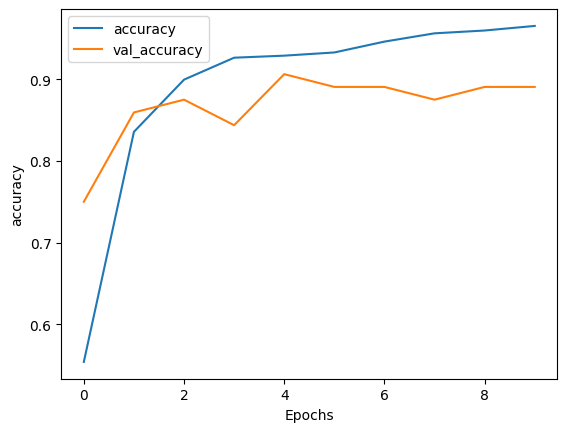

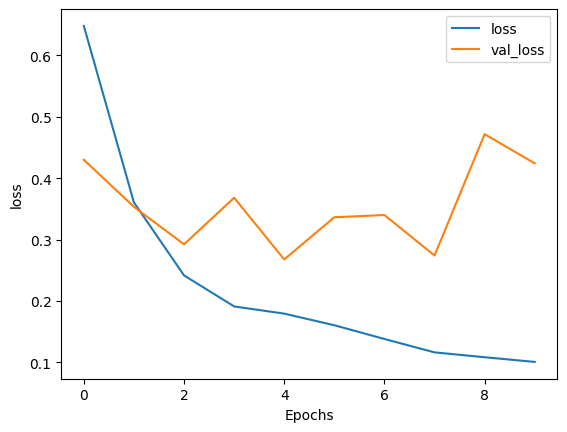

In [16]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

## Hands on
Find a text dataset appropriate for text classification you are interested in available in the [tensorflow dataset collection](https://www.tensorflow.org/datasets/catalog/overview). Try training different versions of RNN models (e.g. LSTM and GRU) and compare the training results such as the loss curves as well as relevant metrics (e.g. accuracy, F1, etc.).

I would suggest that you do this exercise in the iPython console, which is similar to Jupyter Notebook, but works in the terminal. This way you can also try train your models on one of the deepdish servers. 

### TODOs
1. Find and download a dataset you are interested in, and examine the dataset content.
2. Build a `TextVectorizer` for your dataset.
3. Setup classification models based on uni-directional LSTM, uni-directional GRU, bi-directional LSTM and bi-directonal GRU. 
4. Run training and evaluation on these four models and collect results. 
5. Compare the performance in terms of relevant metrics and note the model with best performance. 